# Data Science Lab: Lab 7 part II (of III)

Submit:

A pdf of your notebook with solutions.
A link to your colab notebook or also upload your .ipynb if not working on colab.

## Goals of this Lab: Transfer Learning

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In the previous notebook, we learned how to put together various different types of layers to build a convolutional neural network (CNN) to classify CIFAR-10. Now we are going to learn about the principle of transfer learning.

We will create 2 data sets: one with the first five labels of CIFAR-10 (plane, car, bird, cat, deer), and one with the remaining 5. We will see how training on the second data set, can actually help us with the first.

Note: because CIFAR-10 is a relatively small data set, the numbers are not overly compelling. But we can greatly amplify this if we use larger data sets.

## Problem 1.

Make train and validation (testing) data loaders for the first five labels, and the second five labels.

You should have 4 dataloaders when done.

In [24]:
# First we download the data. This is quite similar to what we've seen before.
# The main difference will be that we need to make two different loaders,
# one for the first five labels, and one for the remaining five.

import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(42)


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

batch_size = 4

# the tutorial calls the dataloader twice -- this code defines a function
# that will do this for the train/test data.

def fetch_dataloader(batch_size, label_subset,transform=None, is_train=True):
    """
    Loads data from disk and returns a data_loader.
    A DataLoader is similar to a list of (image, label) tuples.
    You do not need to fully understand this code to do this assignment, we're happy to explain though.
    """
    data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    # TO DO
    # TO DO
    # TO DO

    # Filter dataset to include only the specified labels
    filtered_indices = [i for i, (_, label) in enumerate(data) if label in label_subset and (i%10 > 0) == is_train]
    filtered_data = torch.utils.data.Subset(data, filtered_indices)

    # train_val_split = [i for i in range(len(data)) if (i%10 > 0) == is_train]
    # filtered_data = torch.utils.data.Subset(filtered_data, train_val_split)

    # Create DataLoader
    loader = torch.utils.data.DataLoader(
        filtered_data, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=2
    )
    return loader


train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [25]:
"""
TO DO

Complete these four using the function you wrote above, to get the 4 data loaders you need:
two for labels 1-5, and two for labels 6-10.
"""
# Define label subsets
first_five_labels = [0, 1, 2, 3, 4]  # 'airplane', 'automobile', 'bird', 'cat', 'deer'
second_five_labels = [5, 6, 7, 8, 9]  # 'dog', 'frog', 'horse', 'ship', 'truck'
data15_train = fetch_dataloader(batch_size, first_five_labels, transform=train_transform, is_train=True)
data15_val = fetch_dataloader(batch_size, first_five_labels, transform=val_transform, is_train=False)
data610_train = fetch_dataloader(batch_size, second_five_labels, transform=train_transform, is_train=True)
data610_val = fetch_dataloader(batch_size, second_five_labels, transform=val_transform, is_train=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


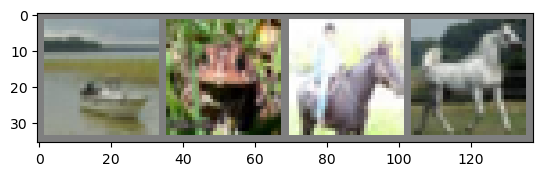

 ship  frog horse horse


In [27]:
# Now let's visualize a few images, to see if this worked.
# Same exact syntax as in the previous notebook.
# Nothing to do here, except run it to make sure it worked.
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(data610_train)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [28]:
# We define the same model from the last notebook
# that we got from the Pytorch ConvNet tutorial.

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [30]:
# We train the model on the first five labels to see how well we do after a fixed amount of training.
#
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Choose a model to train
model1 = ConvNet() # note that this command resets the parameters
model1.to(device)
model1.train()

# Set the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [31]:
for epoch in range(1):  # a single pas through the data. Don't change this.

    running_loss = 0.0
    for i, data in enumerate(data15_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model1(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 2.068
[1,   400] loss: 1.666
[1,   600] loss: 1.568
[1,   800] loss: 1.512
[1,  1000] loss: 1.453
[1,  1200] loss: 1.434
[1,  1400] loss: 1.352
[1,  1600] loss: 1.315
[1,  1800] loss: 1.229
[1,  2000] loss: 1.190
[1,  2200] loss: 1.188
[1,  2400] loss: 1.169
[1,  2600] loss: 1.136
[1,  2800] loss: 1.128
[1,  3000] loss: 1.047
[1,  3200] loss: 1.114
[1,  3400] loss: 1.044
[1,  3600] loss: 1.062
[1,  3800] loss: 1.082
[1,  4000] loss: 1.080
[1,  4200] loss: 0.984
[1,  4400] loss: 1.054
[1,  4600] loss: 1.072
[1,  4800] loss: 0.994
[1,  5000] loss: 1.078
[1,  5200] loss: 0.996
[1,  5400] loss: 0.994
[1,  5600] loss: 0.982
Finished Training


## Problem 2

In the cell above, you trained your model on labels 1-5 for one single epoch.

How well does this do on the validation data set?

This is nearly identical to problems you solved in part I.


In [ ]:
# Set the model to evaluation mode
model1.eval()

# Use the appropriate DataLoader (e.g., data15_val for first 5 labels)
dataloader = data15_val

# Initialize variables to compute accuracy
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for inputs, labels in dataloader:
        # Forward pass: compute predictions
        outputs = model1(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the class index with the highest score

        # Update accuracy metrics
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Calculate and print accuracy
accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 57.33%


In [34]:
# Now we train the model on the last 5 labels to use for transfer learning.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Choose a model to train
model2 = ConvNet() # note that this command resets the parameters
model2.to(device)
model2.train()

# Set the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
for epoch in range(6):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(data610_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels-5 # hack b/c labels are 2-9 instead of 0-7
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model2(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 1.759
[1,  1000] loss: 1.388
[1,  1500] loss: 1.233
[1,  2000] loss: 1.121
[1,  2500] loss: 1.052
[1,  3000] loss: 1.028
[1,  3500] loss: 0.964
[1,  4000] loss: 0.925
[1,  4500] loss: 0.944
[1,  5000] loss: 0.861
[1,  5500] loss: 0.883
[2,   500] loss: 0.812
[2,  1000] loss: 0.806
[2,  1500] loss: 0.777
[2,  2000] loss: 0.759
[2,  2500] loss: 0.755
[2,  3000] loss: 0.738
[2,  3500] loss: 0.743
[2,  4000] loss: 0.701
[2,  4500] loss: 0.699
[2,  5000] loss: 0.746
[2,  5500] loss: 0.699
[3,   500] loss: 0.646
[3,  1000] loss: 0.646
[3,  1500] loss: 0.695
[3,  2000] loss: 0.635
[3,  2500] loss: 0.656
[3,  3000] loss: 0.635
[3,  3500] loss: 0.636
[3,  4000] loss: 0.593
[3,  4500] loss: 0.627
[3,  5000] loss: 0.620
[3,  5500] loss: 0.592
[4,   500] loss: 0.575
[4,  1000] loss: 0.601
[4,  1500] loss: 0.580
[4,  2000] loss: 0.543
[4,  2500] loss: 0.565
[4,  3000] loss: 0.577
[4,  3500] loss: 0.546
[4,  4000] loss: 0.576
[4,  4500] loss: 0.572
[4,  5000] loss: 0.559
[4,  5500] 

Now we see how we can use this model for the first 5 labels.

In [44]:
# We define a new model to fine-tune
model3 = model2



We have a new model: model3. This model has the same weights as model2, hence it is good at classifying labels, 6-10, and does not know about labels 1-5. We will have to reset and retrain the last layer.

## Problem 3

Let's pretend that didn't build model3 ourselves. In this case, to reset the last layer, we would need to figure out what its name is (we know it's fc3, but we're pretending we don't).

Find a command that will tell you the name and type of the last layer.  Print them out.

In [45]:
for name, module in model3.named_modules():
    print(f"Layer name: {name}, Layer type: {type(module)}")

Layer name: , Layer type: <class '__main__.ConvNet'>
Layer name: relu, Layer type: <class 'torch.nn.modules.activation.ReLU'>
Layer name: conv1, Layer type: <class 'torch.nn.modules.conv.Conv2d'>
Layer name: pool, Layer type: <class 'torch.nn.modules.pooling.MaxPool2d'>
Layer name: conv2, Layer type: <class 'torch.nn.modules.conv.Conv2d'>
Layer name: fc1, Layer type: <class 'torch.nn.modules.linear.Linear'>
Layer name: fc2, Layer type: <class 'torch.nn.modules.linear.Linear'>
Layer name: fc3, Layer type: <class 'torch.nn.modules.linear.Linear'>


## Problem 4

If we did the above correctly, then we learned that the last layer is called fc3 and it is a linear layer.

We want to redefine it giving a command like

```
model3.fc3 = nn.Linear(input_features,output_features)
```

* What should be the value of output_features for our new last layer that we are defining? The answer to this comes from the problem we want to solve.

* What is the number of input features that go into this last layer? You'll have to look at the size of the layer defined in the network. Again, pretend we didn't make the network, and we just downloaded it.

So in other words, I'm asking you to use commands to find out how many input features there are for the last layer which (we know from above) is called fc3.

In [46]:
print(model3.fc3)

Linear(in_features=84, out_features=10, bias=True)


## Problem 5

Now redefine the last layer. You will do this with a command like
```
model3.fc3 = # TO DO
```
Note how important it is for us to know what the names of the layers are.

In [47]:
model3.fc3 = nn.Linear(84, 10)
model3 = model3.to(device)
model3.train()

# Let's again check the layers and see the change we made
# (doesn't actually look different since we split 5 and 5)
for name, layer in model2.named_modules():
  print(name,layer)

 ConvNet(
  (relu): ReLU()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
relu ReLU()
conv1 Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
pool MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
conv2 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
fc1 Linear(in_features=400, out_features=120, bias=True)
fc2 Linear(in_features=120, out_features=84, bias=True)
fc3 Linear(in_features=84, out_features=10, bias=True)


In [48]:
# Set the optimizer (loss function already set)
optimizer = torch.optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Problem 6

Check that model3 is no good for classes 1-5. (It shouldn't be any good! We just added a randomly initialized last layer). The accuracy should be close to 20%, which is how good random guessing would be for 5 labels.

Evaluate its accuracy on the validation set for labels 1-5.

In [49]:
# Set the model to evaluation mode
model3.eval()

# Use the appropriate DataLoader (e.g., data15_val for first 5 labels)
dataloader = data15_val

# Initialize variables to compute accuracy
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for inputs, labels in dataloader:
        # Forward pass: compute predictions
        outputs = model3(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the class index with the highest score

        # Update accuracy metrics
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Calculate and print accuracy
accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 5.84%


In [41]:
# Now we train model3 on the first five labels, and evaluate accuracy.
# Nothing for you to do here but run this cell.
# Note that we are also just using one single pass, to make it a fair
# comparison, and so that we can try to see the benefit of transfer learning.
#

for epoch in range(1):  # one single pass -- don't change this

    running_loss = 0.0
    for i, data in enumerate(data15_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model3(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 1.431
[1,   400] loss: 1.096
[1,   600] loss: 1.022
[1,   800] loss: 1.029
[1,  1000] loss: 1.023
[1,  1200] loss: 1.026
[1,  1400] loss: 1.001
[1,  1600] loss: 0.939
[1,  1800] loss: 0.934
[1,  2000] loss: 0.930
[1,  2200] loss: 0.916
[1,  2400] loss: 0.947
[1,  2600] loss: 0.880
[1,  2800] loss: 0.950
[1,  3000] loss: 0.898
[1,  3200] loss: 0.901
[1,  3400] loss: 0.922
[1,  3600] loss: 0.862
[1,  3800] loss: 0.883
[1,  4000] loss: 0.930
[1,  4200] loss: 0.825
[1,  4400] loss: 0.802
[1,  4600] loss: 0.835
[1,  4800] loss: 0.791
[1,  5000] loss: 0.927
[1,  5200] loss: 0.889
[1,  5400] loss: 0.774
[1,  5600] loss: 0.826
Finished Training


## Problem 7

Evaluate the accuracy of model3 (after 1 epoch of training) on the validation set. Compare with the accuracy you found above in Problem 2.

In [43]:
# Set the model to evaluation mode
model3.eval()

# Use the appropriate DataLoader (e.g., data15_val for first 5 labels)
dataloader = data15_val

# Initialize variables to compute accuracy
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for inputs, labels in dataloader:
        # Forward pass: compute predictions
        outputs = model3(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the class index with the highest score

        # Update accuracy metrics
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Calculate and print accuracy
accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 69.40%


The Validation Accuracy is much higher at 69.4% compared to the 57.33% accuracy from the previous model, proving the effectiveness of transfer learning.